In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import (Dense, Conv2D, Input, MaxPool2D, 
                         UpSampling2D, Concatenate, Conv2DTranspose, 
                         Dropout, Cropping2D)
import tensorflow as tf
from keras.optimizers import Adam,SGD
from keras.initializers import he_normal
from keras.models import load_model
from scipy.misc import imresize
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from keras.preprocessing.image import (array_to_img, img_to_array, 
                                       load_img, ImageDataGenerator)
from keras.callbacks import (Callback, ModelCheckpoint, CSVLogger, 
                             ReduceLROnPlateau)
import keras.backend as K
import itchat
from wechat_utils import SendMessage
import random
from importlib import reload

import pdb
import gc
import sys

Using TensorFlow backend.


/home/luo/anaconda2/envs/tf11/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
import keras
keras.__version__

'2.0.5'

## Prepare the data

In [3]:
# Set the necessary directories
data_dir = '../data/train/'
mask_dir = '../data/train_masks/'
all_images = os.listdir(data_dir)

In [4]:
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


In [5]:
tmp_dir = './tmp/u-net-valid-padding/'

In [6]:
!mkdir ./tmp/u-net-valid-padding/

mkdir: cannot create directory ‘./tmp/u-net-valid-padding/’: File exists


In [7]:
# Train validation split
train_images, validation_images = train_test_split(
    all_images, train_size=0.8, test_size=0.2)

In [8]:
# original size 1280, 1918
image_size = [906, 640]
input_dims = [572, 572]
output_dims = [388, 388]
batch_size = 4

In [9]:
# Utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j]) * 3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

In [10]:
def read_image_and_mask(data_dir, mask_dir, image):
    return (load_img(data_dir + image), 
            load_img(mask_dir + image.split('.')[0] + '_mask.gif'))

In [11]:
def show_image_and_mask(image, mask):
    plt.figure()
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(mask)

(572, 572)
[[ 238.  234.  231.]
 [ 238.  234.  231.]
 [ 238.  234.  231.]
 ..., 
 [ 115.  113.  101.]
 [ 115.  113.  101.]
 [ 115.  113.  101.]]


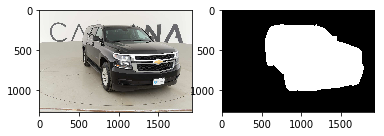

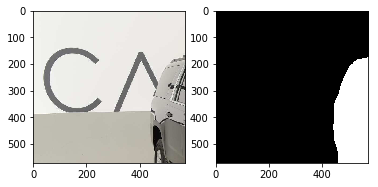

In [12]:
def random_crop(image_pair, dims):
    image, mask = image_pair
    w, h = image.size
    x_s = random.randint(0, w - dims[1])
    y_s = random.randint(0, h - dims[0])
    box = (x_s, y_s, x_s+dims[1], y_s+dims[0])
    image = image.crop(box)
    mask = mask.crop(box)
    return image, mask
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = random_crop((image_, mask_), input_dims)
show_image_and_mask(image_, mask_)
print (image_.size)
print (img_to_array(image_)[:, input_dims[1]-1])

In [13]:
%%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
image_ = image_.resize(image_size, resample=Image.BILINEAR)
mask_ = mask_.resize(image_size, resample=Image.BILINEAR)

CPU times: user 84 ms, sys: 8 ms, total: 92 ms
Wall time: 100 ms


In [14]:
%%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

CPU times: user 112 ms, sys: 12 ms, total: 124 ms
Wall time: 131 ms


(906, 640)
[[ 236.  233.  226.]
 [ 236.  233.  226.]
 [ 236.  233.  226.]
 ..., 
 [ 187.  178.  167.]
 [ 201.  194.  185.]
 [ 215.  210.  202.]]


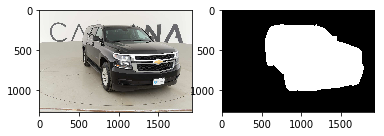

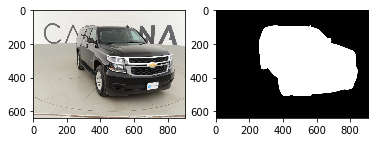

In [15]:
def resize_image(image_pair, dims):
    image, mask = image_pair
    image = image.resize(dims, resample=Image.BILINEAR)
    mask = mask.resize(dims, resample=Image.BILINEAR)
    return image, mask
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = resize_image((image_, mask_), image_size)
show_image_and_mask(image_, mask_)
print (image_.size)
print (img_to_array(image_)[:, input_dims[1]-1])

(1918, 1280)
[[ 235.  236.  231.]
 [ 235.  236.  231.]
 [ 235.  236.  231.]
 ..., 
 [ 222.  218.  215.]
 [ 222.  216.  216.]
 [ 221.  215.  215.]]


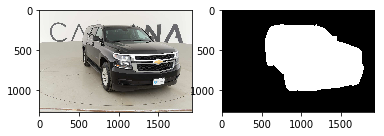

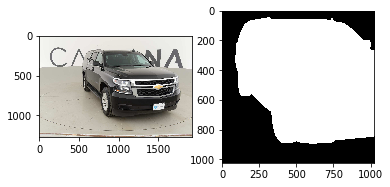

In [16]:
def cut_mask(image_pair, dims):
    assert dims[0] % 2 == 0 and dims[1] % 2 == 0, 'Output dims must be even numbers.'
    image, mask = image_pair
    # Because the image size is reversed of what we defined
    original_dims = image.size[::-1]
    x_s = (original_dims[1] - dims[1]) / 2
    y_s = (original_dims[0] - dims[0]) / 2
    box = (x_s, y_s, x_s+dims[1], y_s+dims[0])
    mask = mask.crop(box)
    return image, mask
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = cut_mask((image_, mask_), [1024, 1024])
show_image_and_mask(image_, mask_)
print (image_.size)
print (img_to_array(image_)[:, input_dims[1]-1])

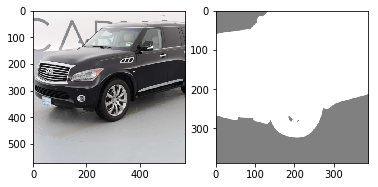

In [17]:
from data_utils import random_horizontal_flip
transform_resize = lambda image_pair: resize_image(image_pair, image_size)
transform_flip = lambda image_pair: random_horizontal_flip(image_pair, prob=0.5)
transform_crop = lambda image_pair: random_crop(image_pair, input_dims)
transform_cut = lambda image_pair: cut_mask(image_pair, output_dims)
transforms = [transform_resize, transform_flip, transform_crop, transform_cut]

from data_utils import data_gen_small, threadsafe_iter
import data_utils
reload(data_utils)
del globals()['data_gen_small']
from data_utils import data_gen_small
            
# Example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, batch_size, 
                          input_dims, transforms=transforms)
img, msk = next(train_gen)

plt.subplot(121)
plt.imshow(img[0])
plt.subplot(122)
plt.imshow(grey2rgb(msk[0]), alpha=0.5)

In [18]:
%%time
_ = next(train_gen)

CPU times: user 364 ms, sys: 4 ms, total: 368 ms
Wall time: 429 ms


In [19]:
val_gen = data_gen_small(data_dir, mask_dir, validation_images, 512, input_dims, transforms=transforms)

In [20]:
val_images, val_masks = next(val_gen)

In [21]:
print (val_images.shape)
print (val_masks.shape)

(512, 572, 572, 3)
(512, 388, 388, 1)


In [22]:
image_, mask_ = next(train_gen)
print (image_.shape)
print (mask_.shape)
print (mask_[0].shape)
print (mask_[0][150])
print (mask_[0].sum())

(4, 572, 572, 3)
(4, 388, 388, 1)
(388, 388, 1)
[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.  

## Build the network

In [23]:
# First, let's define the two different types of layers that we will 
# be using
def down(input_layer, filters, pool=True, padding='same', verbose=1):
    conv1 = Conv2D(filters, (3, 3), padding=padding, 
                   kernel_initializer=he_normal(), activation='relu')(
                   input_layer)
    residual = Conv2D(filters, (3, 3), padding=padding, 
                      kernel_initializer=he_normal(), activation='relu')(
                      conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        if verbose:
            print ('Down output shape')
            print ('max_pool {}, residual {}'.format(K.int_shape(max_pool), K.int_shape(residual)))
        return max_pool,residual
    else:
        if verbose:
            print ('Down output shape')
            print ('residual {}'.format(K.int_shape(residual)))
        return residual
    
def up(input_layer, residual, filters, padding='same', cropping=0, verbose=1):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding='same', 
                    kernel_initializer=he_normal(), activation='relu')(upsample)
    if cropping != 0:
        residual = Cropping2D(cropping=cropping)(residual)

    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding=padding,
                   kernel_initializer=he_normal(), activation='relu')(
                   concat)
    conv2 = Conv2D(filters, (3, 3), padding=padding, 
                   kernel_initializer=he_normal(), activation='relu')(
                   conv1)
    if verbose:
        print ('Up output dims')
        print (K.int_shape(conv2))
    return conv2


In [24]:
K.clear_session()
# Make a custom U-nets implementation
padding = 'valid'
cropping = ((4, 4), (16, 16), (40, 40), (88, 88))
filters = 64

input_layer = Input(shape=[None, None] + [3])
layers = [input_layer]
residuals = []

# Down 1, 128
d1, res1 = down(input_layer, filters, padding=padding)
residuals.append(res1)

# Down 2, 64
filters = filters * 2
d2, res2 = down(d1, filters, padding=padding)
residuals.append(res2)

# Down 3 32
filters = filters * 2
d3, res3 = down(d2, filters, padding=padding)
residuals.append(res3)

# Down 4, 16
filters = filters * 2
d4, res4 = down(d3, filters, padding=padding)
residuals.append(res4)

# Down 5, 8
filters = filters * 2
d4 = Dropout(0.5)(d4)
d5 = down(d4, filters, pool=False, padding=padding)
d5 = Dropout(0.5)(d5)

# Up 1
filters = filters / 2
up1 = up(d5, residual=residuals[-1], filters=filters, padding=padding, cropping=cropping[0])

# Up 2,3,4
up_ = up1
for layer_i in range(3):
    filters = filters / 2
    up_ = up(up_, residual=residuals[-(layer_i + 2)], filters=filters, 
             padding=padding, cropping=cropping[layer_i+1])
    
# Out, or up 5
out = Conv2D(filters=1, kernel_size=(1, 1), kernel_initializer=he_normal(), 
             activation='sigmoid', padding=padding)(up_)

model = Model(input_layer, out)
model.summary()

Down output shape
max_pool (None, None, None, 64), residual (None, None, None, 64)
Down output shape
max_pool (None, None, None, 128), residual (None, None, None, 128)
Down output shape
max_pool (None, None, None, 256), residual (None, None, None, 256)
Down output shape
max_pool (None, None, None, 512), residual (None, None, None, 512)
Down output shape
residual (None, None, None, 1024)
Up output dims
(None, None, None, 512)
Up output dims
(None, None, None, 256)
Up output dims
(None, None, None, 128)
Up output dims
(None, None, None, 64)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None,

In [25]:
# Parameters distribution
# For convnet, parameters number = size_w * size_h * pre_depth * 
# curr_depth
# increase intial depth by 2 will result 4x params 
# Down 
# 2k 37k
# 74k 148k
# 295k 590k
# 1180k 2400k
# 4720k 9438k
# Up
# 2098k 4719k 2360k
# 524k 1180k 590k
# 131k 295k 148k
# 33k 74k 37k
# 0k last 1x1 conv
# Total, 31032k

In [26]:
# Computation (multiply) 
# Down
# 3 * 64 * 9 * 570^2 = 561m
# 64 * 64 * 9 * 568^2 = 11893m
# 64 * 128 * 9 * 280^2 * 3 = 17340m
# 128 * 256 * 9 * 136^2 * 3 = 16264m
# 256 * 512 * 9 * 64^2 * 3 = 14496m
# 512 * 1024 * 9 * 28^2 * 3 = 11098m
# Down in all, 71652m
# Up
# 1024 * 512 * 4 * 56^2 = 6576m
# 1024 * 512 * 9 * 52^2 * 1.5 = 19139m
# 512 * 256 * 4 * 104^2 = 5671m
# 512 * 256 * 9 * 100^2 * 1.5 = 17695m
# 256 * 128 * 4 * 200^2 = 5243m
# 256 * 128 * 9 * 196^2 * 1.5 = 16994m
# 128 * 64 * 4 * 392^ 2 = 5035m
# 128 * 64 * 9 * 388^2 * 1.5 = 16648m
# Up in all, 93001m
# Omit last 1x1 conv and activation
# Total, 164653m ~ 0.16T
# Every layer, computation is almost the same, becasue the size decrease
# by a factor of 2, while filter increase by factor of 2
# Increase the filter size will significantly increase the computation
# Increase input size by 2, the number of multiplication will x4
# Increase intial depth by 2, the number of mutiplication will x4

In [27]:
# Now let's use Tensorflow to write our dice_coefficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape((y_true), [-1]))
    y_pred = tf.round(tf.reshape((y_pred), [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [28]:
# Model checkpoint
checkpoint = ModelCheckpoint(filepath=tmp_dir + 'weights.hdf5',
                             verbose=1, save_best_only=True)
csv_logger = CSVLogger(tmp_dir + 'training.log')
send_message = SendMessage(fexten=tmp_dir)

Please press confirm on your phone.
Loading the contact, this may take a little while.
Login successfully as LUO FAN


In [47]:
#optimizer = SGD(lr=0.001, momentum=0.99)
optimizer = SGD(lr=0.001, momentum=0.99)
model.compile(optimizer=optimizer, loss='binary_crossentropy', 
             metrics=[dice_coef])

In [48]:
# For keras 2.0.5, the max_queue_size should be max_q_size
# no relu in 2x2 conv, no advanced initializer
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, send_message], 
                              validation_data=(val_images, val_masks), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=2, 
                              initial_epoch=0)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., workers=1, max_queue_size=6, epochs=2, initial_epoch=0, validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=1024.0, validation_steps=inf)`
  # This is added back by InteractiveShellApp.init_path()
Start auto replying.


Epoch 1/2
1024/1024 [==============================] - 3339s - loss: 0.4045 - dice_coef: 0.7999 - val_loss: 0.1740 - val_dice_coef: 0.9382
Epoch 2/2
1024/1024 [==============================] - 3312s - loss: 0.0988 - dice_coef: 0.9648 - val_loss: 0.0579 - val_dice_coef: 0.9785


In [49]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, send_message], 
                              validation_data=next(val_gen), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=3, 
                              initial_epoch=2)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., workers=1, max_queue_size=6, epochs=3, initial_epoch=2, validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=1024.0, validation_steps=inf)`
  # This is added back by InteractiveShellApp.init_path()
Start auto replying.


Epoch 3/3
1024/1024 [==============================] - 3314s - loss: 0.0518 - dice_coef: 0.9819 - val_loss: 0.0429 - val_dice_coef: 0.9846


In [ ]:
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, send_message], 
                              validation_data=next(val_gen), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=4, 
                              initial_epoch=3)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., workers=1, max_queue_size=6, epochs=4, initial_epoch=3, validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=1024.0, validation_steps=inf)`
  if __name__ == '__main__':
Start auto replying.


Epoch 4/4
1024/1024 [==============================] - 3316s - loss: 0.0353 - dice_coef: 0.9877 - val_loss: 0.0323 - val_dice_coef: 0.9889


In [52]:
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, send_message], 
                              validation_data=next(val_gen), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=10, 
                              initial_epoch=4)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., workers=1, max_queue_size=6, epochs=10, initial_epoch=4, validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=1024.0, validation_steps=inf)`
  if __name__ == '__main__':
Start auto replying.


Epoch 5/10
 302/1024 [=======>......................] - ETA: 2248s - loss: 0.0303 - dice_coef: 0.9895
 GPU 

1024/1024 [==============================] - 3314s - loss: 0.0292 - dice_coef: 0.9899 - val_loss: 0.0252 - val_dice_coef: 0.9913
Epoch 6/10
1024/1024 [==============================] - 3310s - loss: 0.0246 - dice_coef: 0.9915 - val_loss: 0.0273 - val_dice_coef: 0.9907
Epoch 7/10
1024/1024 [==============================] - 3313s - loss: 0.0228 - dice_coef: 0.9922 - val_loss: 0.0264 - val_dice_coef: 0.9909
Epoch 8/10
1024/1024 [==============================] - 3314s - loss: 0.0239 - dice_coef: 0.9918 - val_loss: 0.0214 - val_dice_coef: 0.9926
Epoch 9/10
1024/1024 [==============================] - 3314s - loss: 0.0191 - dice_coef: 0.9935 - val_loss: 0.0212 - val_dice_coef: 0.9928
Epoch 10/10
1024/1024 [==============================] - 3316s - loss: 0.0178 - dice_coef: 0.9940 - val_loss: 0.0179 - val_dice_coef: 0.9940


In [56]:
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef')

In [29]:
custom_objects = {'dice_coef': dice_coef}
model = load_model(tmp_dir + 'weights.hdf5', custom_objects=custom_objects)

In [67]:
tmp_dir

'./tmp/u-net-dropout-momentum/'

In [ ]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, send_message, reduce_lr], 
                              validation_data=next(val_gen), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=30, 
                              initial_epoch=10)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., workers=1, max_queue_size=6, epochs=30, initial_epoch=10, validation_data=(array([[[..., callbacks=[<keras.ca..., steps_per_epoch=1024.0, validation_steps=inf)`
  # Remove the CWD from sys.path while we load stuff.
Start auto replying.


Epoch 11/30
1024/1024 [==============================] - 3315s - loss: 0.0213 - dice_coef: 0.9927 - val_loss: 0.0183 - val_dice_coef: 0.9938
Epoch 12/30
1024/1024 [==============================] - 3324s - loss: 0.0167 - dice_coef: 0.9943 - val_loss: 0.0178 - val_dice_coef: 0.9940
Epoch 13/30
1024/1024 [==============================] - 3318s - loss: 0.0169 - dice_coef: 0.9943 - val_loss: 0.0162 - val_dice_coef: 0.9945
Epoch 14/30
1024/1024 [==============================] - 3320s - loss: 0.0152 - dice_coef: 0.9949 - val_loss: 0.0152 - val_dice_coef: 0.9949
Epoch 15/30
1024/1024 [==============================] - 3318s - loss: 0.0142 - dice_coef: 0.9952 - val_loss: 0.0147 - val_dice_coef: 0.9951
Epoch 16/30
 533/1024 [==============>...............] - ETA: 1531s - loss: 0.0140 - dice_coef: 0.9953

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


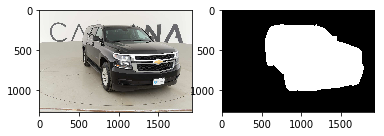

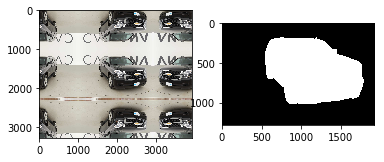

In [30]:
def pad_image(image, pad_width, mode='symmetric'):
    array = img_to_array(image)
    padding = ((pad_width, pad_width), (pad_width, pad_width), (0, 0))
    padded_array = np.pad(array, padding, mode=mode)
    padded_image = array_to_img(padded_array)
    return padded_image
%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_ = pad_image(image_, 1000)
show_image_and_mask(image_, mask_)

In [31]:
array_ = img_to_array(image_)
array_.shape

(3280, 3918, 3)

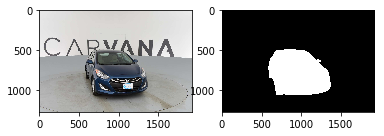

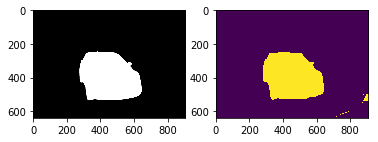

In [77]:
def predict_on_patch(model, image, pad_width, image_size, input_size, output_size, verbose=0):
    """
    image:    PIL Image
    """
    image = imresize(image, image_size[::-1])
    image = pad_image(image, pad_width)
    array = img_to_array(image) / 255
    mask = np.zeros(image_size[::-1])
    h, w = array.shape[0:2]
    mask_h, mask_w = mask.shape
    
    patch_width = output_size[0]
    patch_high = output_size[1]
    assert patch_width == patch_high, 'Output_size must be square'
    
    input_patch_width = input_size[0]
    input_patch_high = input_size[1]
    assert input_patch_width == input_patch_high, 'Input_size must be square'
    
    if verbose:
        plt.figure()
        plt.imshow(image)
        plt.show()
    
    # Function for judge the position of the patch
    def _is_last_col():
        return patch_width * i + input_patch_width > w
    def _is_last_row():
        return patch_high * j + input_patch_high > h
    
    # Predict patch by patch
    for i in range(int(np.ceil((w - input_patch_width) / patch_width)) + 1):
        for j in range(int(np.ceil((h - input_patch_high) / patch_high)) + 1):
            
            xs = i * patch_width
            xe = xs + input_patch_width
            ys = j * patch_high
            ye = ys + input_patch_high
            
            if (_is_last_row()):
                ys = h - input_patch_high
                ye = h
            if (_is_last_col()):
                xs = w - input_patch_width
                xe = w
                
            if verbose:
                print ('Now processing ({}, {}), ({}, {}).'.
                       format(xs, ys, xe, ye))
            
            # Predict the patch
            patch = array[ys:ye, xs:xe]
            patch = patch[None,:,:,:]
            output_patch = model.predict(patch, batch_size=1)
            
            if verbose:
                show_image_and_mask(patch[0], output_patch[0,:,:,0])
            
            # Fill the mask
            xs = i * patch_width
            xe = (i + 1) * patch_width
            ys = j * patch_high
            ye = (j + 1) * patch_high
            if (_is_last_row()):
                ys = mask_h - patch_high
                ye = mask_h
            if (_is_last_col()):
                xs = mask_w - patch_width
                xe = mask_w
            mask[ys:ye, xs:xe] = output_patch[0,:,:,0]
            
    return mask

image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[0])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])
mask_pred_ = predict_on_patch(model, image_, 96, image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(mask_, mask_pred_)

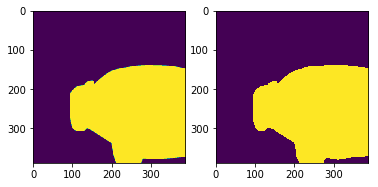

In [52]:
mask_pred_ = model.predict(val_images[0][None,:,:,:])
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(val_masks[0][:,:,0], mask_pred_[0,:,:,0])

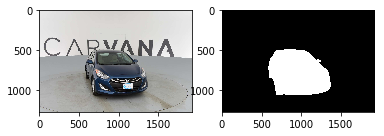

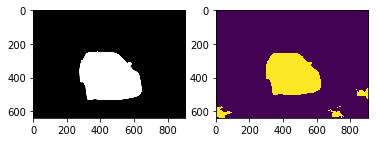

In [95]:
def mirror_average_prediction(model, image, pad_width, image_size, input_size, output_size):
    image = pad_image(image, pad_width)
    image2 = image.transpose(Image.FLIP_LEFT_RIGHT)
    mask = predict_on_patch(model, image, pad_width, image_size, input_size, output_size)
    mask2 = predict_on_patch(model, image2, pad_width, image_size, input_size, output_size)
    mask = mask + np.fliplr(mask2)
    mask /= 2.
    mask[mask>=0.5] = 1
    mask[mask<0.5] = 0
    return mask
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[0])
show_image_and_mask(image_, mask_)
mask_ = imresize(mask_, image_size[::-1])
mask_pred_ = mirror_average_prediction(model, image_, 96, image_size, input_dims, output_dims)
show_image_and_mask(mask_, mask_pred_)

In [96]:
mask_[400,400]

array([255, 255, 255], dtype=uint8)

In [97]:
(mask_ / 255.)[400,400,1]

1.0

In [98]:
mask_pred_[400,400]

1.0

In [93]:
def cal_dice_coef(mask1, mask2):
    mask1 = (mask1 / 255.)[:,:,1]
    intersection = np.intersect1d(mask1, mask2).size
    return 2. * intersection / (mask1 + mask2).sum()
cal_dice_coef(mask_, mask_pred_)

2.4901046415208741e-05

In [77]:
val_batch_size = 32
for i in range(5):
    idx = random.sample(range(1018), 32)
    print (model.evaluate(val_images[idx], val_masks[idx], batch_size=4))

32/32 [==============================] - 44s    
[0.0096099799848161638, 0.99210716038942337]
32/32 [==============================] - 32s    
[0.0086611862061545253, 0.99208315461874008]
32/32 [==============================] - 32s    
[0.0086834862595424056, 0.99218709021806717]
32/32 [==============================] - 32s    
[0.0087706092745065689, 0.9921201691031456]
32/32 [==============================] - 32s    
[0.010245724464766681, 0.99241621792316437]


In [78]:
val_batch_size = 128
for i in range(5):
    idx = random.sample(range(1018), val_batch_size)
    print (model.evaluate(val_images[idx], val_masks[idx], batch_size=4))

128/128 [==============================] - 147s   
[0.0091556776314973831, 0.9917932003736496]
128/128 [==============================] - 153s   
[0.0090488984278636053, 0.99217040836811066]
128/128 [==============================] - 148s   
[0.0089989591797348112, 0.99243416078388691]
128/128 [==============================] - 152s   
[0.0085197681473800912, 0.99259385466575623]
128/128 [==============================] - 138s   
[0.0094432907935697585, 0.99163399077951908]
